##### Installing the dependencies and importing required stuff

In [ ]:
%pip install -r requrements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from pprint import pprint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import make_scorer, homogeneity_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from collections import Counter
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')


## 1. Dataset Exploration & Preprocessing

First, we load the dataset.

In [4]:
dataset = pd.read_csv('covtype.csv')

X = dataset.drop(columns=['Cover_Type'])
y = dataset['Cover_Type']

dataset.head(3)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


#### 1.1. Helper functions for data Exploration

In [6]:
def plot_label_distribution(column):
    if not isinstance(column, pd.Series):
        raise ValueError("Input must be a pandas Series.")

    label_counts = column.value_counts().sort_index()
    
    plt.figure(figsize=(8, 6))
    ax = label_counts.plot(kind='bar')
    plt.title(f"Distribution of Labels in Column '{column.name}'", fontsize=14)
    plt.xlabel("Labels", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    
    max_count = label_counts.max()
    ax.set_ylim(0, max_count * 1.1)
    for i, count in enumerate(label_counts):
        ax.text(i, count + (0.02 * max_count), str(count), ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def one_hot_correlation_plot(dataframe, target_column, method='spearman'):
    if target_column not in dataframe.columns:
        raise ValueError(f"Target column '{target_column}' not found in the dataframe.")

    target_one_hot = pd.get_dummies(dataframe[target_column], prefix=target_column)
    numeric_features = dataframe.drop(columns=[target_column]).select_dtypes(include=[np.number])
    
    if numeric_features.empty:
        raise ValueError("No numeric features available for correlation analysis.")
    
    correlations = {}
    for col in target_one_hot.columns:
        corr = numeric_features.corrwith(target_one_hot[col], method=method)
        correlations[col] = corr.sort_values(ascending=False)
    
    for category, corr_series in correlations.items():
        plt.figure(figsize=(10, 8))
        sns.barplot(x=corr_series.index, y=corr_series.values, palette="coolwarm", edgecolor="black")
        plt.title(f"{method.capitalize()} Correlation with Target Category: '{category}'", fontsize=12)
        plt.ylabel('Correlation Coefficient', fontsize=12)
        plt.xlabel("")  
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

def average_absolute_correlation_plot(dataframe, target_column, method='spearman'):
    if target_column not in dataframe.columns:
        raise ValueError(f"Target column '{target_column}' not found in the dataframe.")

    target_one_hot = pd.get_dummies(dataframe[target_column], prefix=target_column)
    numeric_features = dataframe.drop(columns=[target_column]).select_dtypes(include=[np.number])
    
    if numeric_features.empty:
        raise ValueError("No numeric features available for correlation analysis.")

    correlation_matrix = []
    for col in target_one_hot.columns:
        corr = numeric_features.corrwith(target_one_hot[col], method=method).abs()
        correlation_matrix.append(corr)

    correlation_df = pd.DataFrame(correlation_matrix, index=target_one_hot.columns).T
    average_absolute_correlation = correlation_df.mean(axis=1)
    average_absolute_correlation = average_absolute_correlation.sort_values(ascending=False)

    # Plot the average absolute correlations
    plt.figure(figsize=(10, 8))
    sns.barplot(x=average_absolute_correlation.index, y=average_absolute_correlation.values, palette="coolwarm", edgecolor="black")
    plt.title(f"Average Absolute {method.capitalize()} Correlation with Target Classes", fontsize=12)
    plt.ylabel('Average Absolute Correlation Coefficient', fontsize=12)
    plt.xlabel("")
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def print_low_correlation_features(dataframe, target_column, threshold=0.1, method='spearman'):
    if target_column not in dataframe.columns:
        raise ValueError(f"Target column '{target_column}' not found in the dataframe.")

    target_one_hot = pd.get_dummies(dataframe[target_column], prefix=target_column)
    numeric_features = dataframe.drop(columns=[target_column]).select_dtypes(include=[np.number])

    if numeric_features.empty:
        raise ValueError("No numeric features available for correlation analysis.")

    correlation_matrix = []
    for col in target_one_hot.columns:
        corr = numeric_features.corrwith(target_one_hot[col], method=method).abs()
        correlation_matrix.append(corr)

    correlation_df = pd.DataFrame(correlation_matrix, index=target_one_hot.columns).T
    low_correlation_features = correlation_df[(correlation_df < threshold).all(axis=1)].index.tolist()

    if low_correlation_features:
        print(f"Features with absolute correlation below {threshold} for all target categories:")
        for feature in low_correlation_features:
            print(f"- {feature}")
        return low_correlation_features
    else:
        print(f"No features found with absolute correlation below {threshold} for all target categories.")
        return []
    
def analyze_features(df):
    """
    Analyzes features in the DataFrame and prints their types and value ranges.
    """
    feature_summary = {}

    for column in df.columns:
        unique_values = df[column].nunique()
        total_values = len(df[column])

        if pd.api.types.is_numeric_dtype(df[column]):
            if unique_values == 2:
                feature_type = "Binary"
            else:
                feature_type = "Numerical"
            value_range = (df[column].min(), df[column].max())
        else:
            feature_type = "Categorical"
            value_range = df[column].unique()

        feature_summary[column] = {
            "Type": feature_type,
            "Value Range": value_range,
        }

    for feature, details in feature_summary.items():
        print(f"Feature: {feature}")
        print(f"  Type: {details['Type']}")
        print(f"  Value Range: {details['Value Range']}")
        print("-")

def plot_max_correlation_for_features(dataframe, target_column, method='spearman'):
    if target_column not in dataframe.columns:
        raise ValueError(f"Target column '{target_column}' not found in the dataframe.")
    
    target_one_hot = pd.get_dummies(dataframe[target_column], prefix=target_column)
    numeric_features = dataframe.drop(columns=[target_column]).select_dtypes(include=[np.number])

    if numeric_features.empty:
        raise ValueError("No numeric features available for correlation analysis.")
    
    correlation_matrix = []
    for col in target_one_hot.columns:
        corr = numeric_features.corrwith(target_one_hot[col], method=method)
        correlation_matrix.append(corr)

    correlation_df = pd.DataFrame(correlation_matrix, index=target_one_hot.columns).T
    
    max_correlation_values = correlation_df.max(axis=1)
    
    sorted_correlation = max_correlation_values.sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_correlation.index, sorted_correlation.values, color='skyblue')
    plt.title("Maximum Correlation for Each Feature with Labels")
    plt.ylabel("Correlation")
    plt.xlabel("Features")
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

#### 1.2. Performing Data Exploration

Look at feature types and value ranges

In [7]:
analyze_features(dataset)

Feature: Elevation
  Type: Numerical
  Value Range: (1859, 3858)
-
Feature: Aspect
  Type: Numerical
  Value Range: (0, 360)
-
Feature: Slope
  Type: Numerical
  Value Range: (0, 66)
-
Feature: Horizontal_Distance_To_Hydrology
  Type: Numerical
  Value Range: (0, 1397)
-
Feature: Vertical_Distance_To_Hydrology
  Type: Numerical
  Value Range: (-173, 601)
-
Feature: Horizontal_Distance_To_Roadways
  Type: Numerical
  Value Range: (0, 7117)
-
Feature: Hillshade_9am
  Type: Numerical
  Value Range: (0, 254)
-
Feature: Hillshade_Noon
  Type: Numerical
  Value Range: (0, 254)
-
Feature: Hillshade_3pm
  Type: Numerical
  Value Range: (0, 254)
-
Feature: Horizontal_Distance_To_Fire_Points
  Type: Numerical
  Value Range: (0, 7173)
-
Feature: Wilderness_Area1
  Type: Binary
  Value Range: (0, 1)
-
Feature: Wilderness_Area2
  Type: Binary
  Value Range: (0, 1)
-
Feature: Wilderness_Area3
  Type: Binary
  Value Range: (0, 1)
-
Feature: Wilderness_Area4
  Type: Binary
  Value Range: (0, 1)
-
Feat

In [8]:
numerical_features = dataset.iloc[:, :10]
description = numerical_features.describe()
desc_filtered = description.drop(index=['25%', '50%', '75%', 'count'])
desc_transposed = desc_filtered.T

print(desc_transposed)

                                           mean          std     min     max
Elevation                           2959.365301   279.984734  1859.0  3858.0
Aspect                               155.656807   111.913721     0.0   360.0
Slope                                 14.103704     7.488242     0.0    66.0
Horizontal_Distance_To_Hydrology     269.428217   212.549356     0.0  1397.0
Vertical_Distance_To_Hydrology        46.418855    58.295232  -173.0   601.0
Horizontal_Distance_To_Roadways     2350.146611  1559.254870     0.0  7117.0
Hillshade_9am                        212.146049    26.769889     0.0   254.0
Hillshade_Noon                       223.318716    19.768697     0.0   254.0
Hillshade_3pm                        142.528263    38.274529     0.0   254.0
Horizontal_Distance_To_Fire_Points  1980.291226  1324.195210     0.0  7173.0


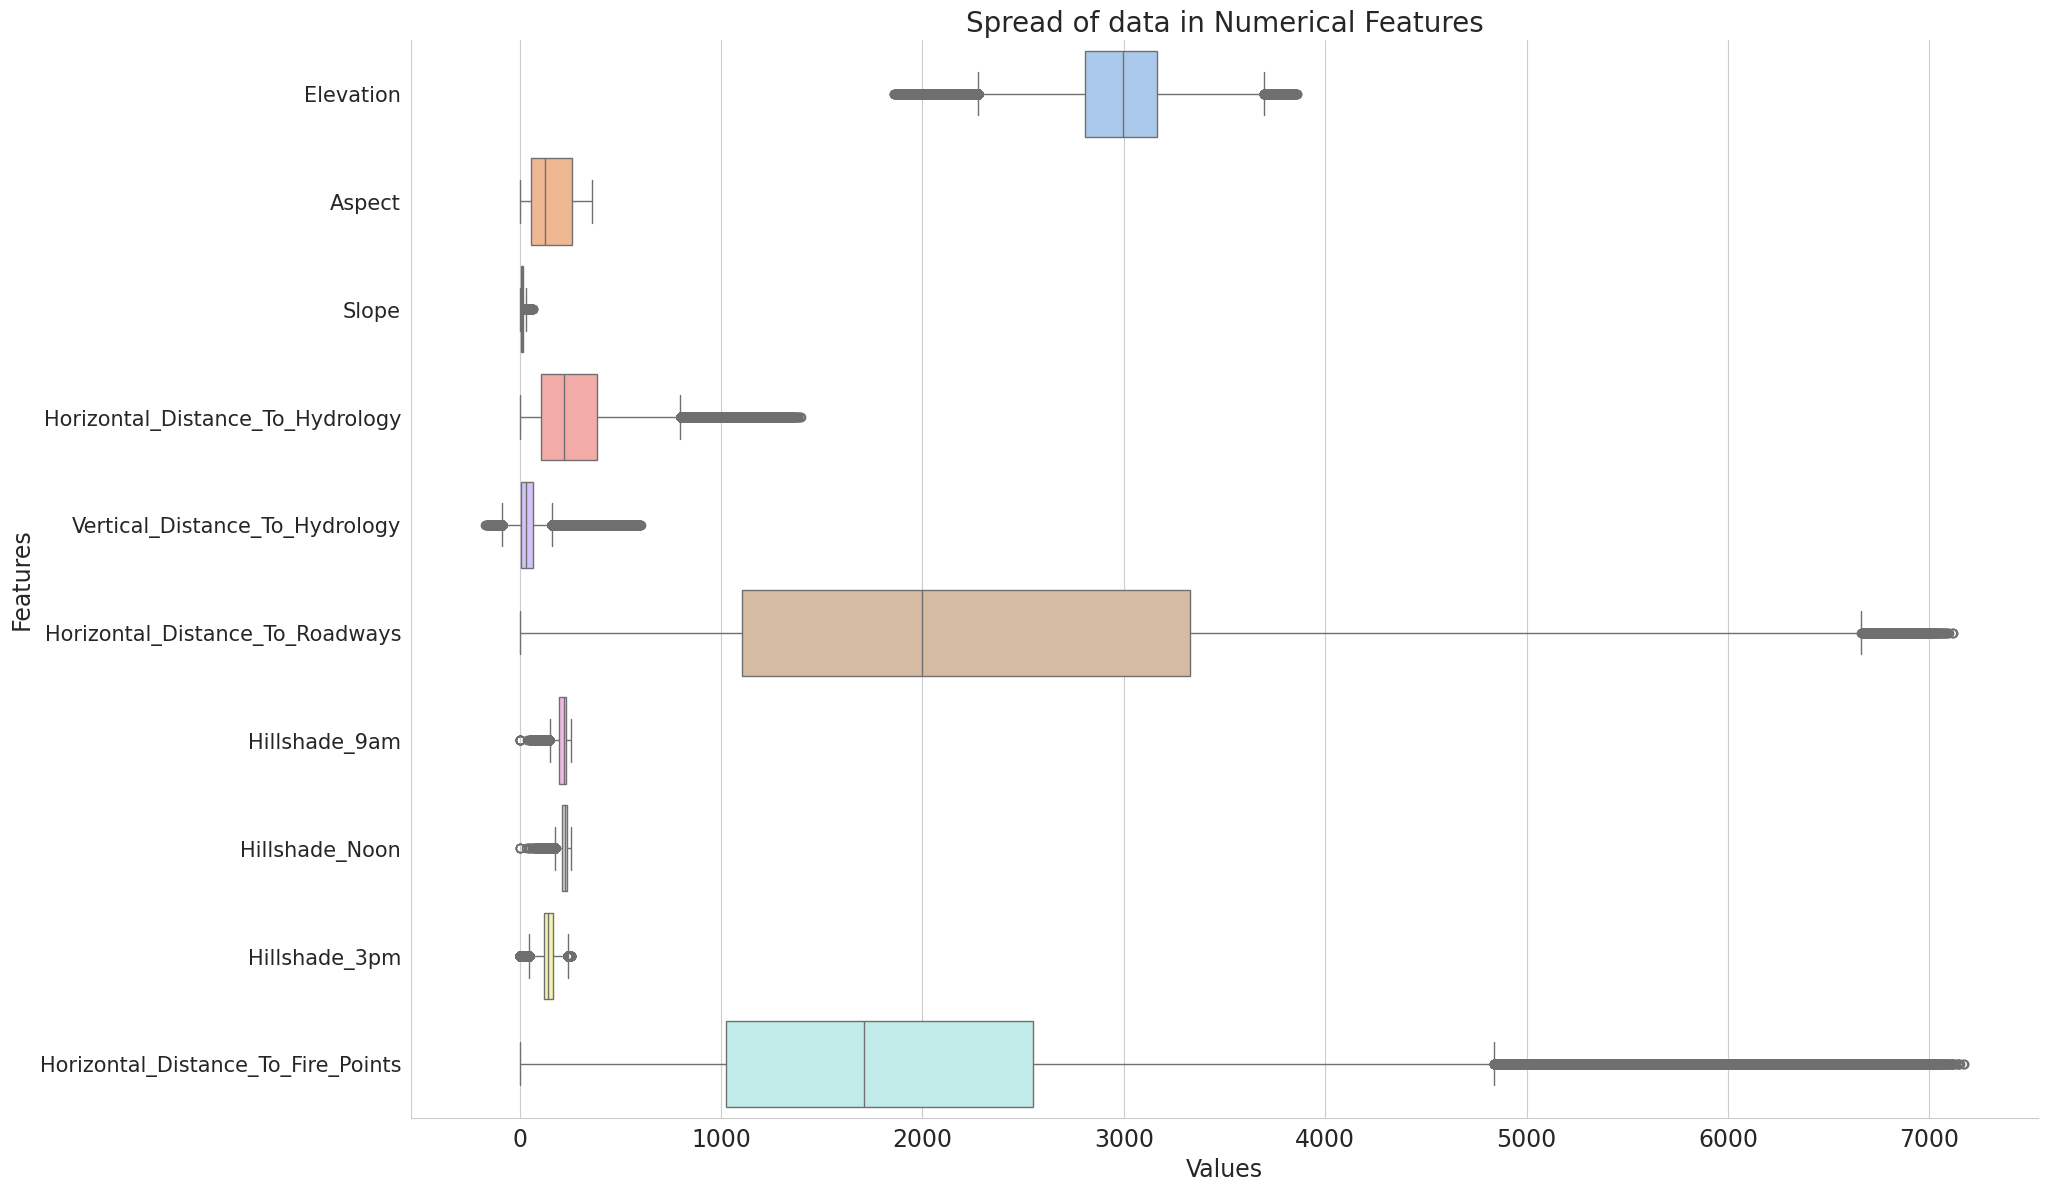

In [9]:
sns.set_style("whitegrid")
plt.subplots(figsize=(21, 14))

color = sns.color_palette('pastel')
sns.boxplot(data = numerical_features, orient='h', palette=color)

plt.title('Spread of data in Numerical Features', size = 20)
plt.xlabel('Values', size = 17)
plt.ylabel('Features', size = 17)
plt.xticks(size = 17)
plt.yticks(size = 15)

sns.despine()
plt.show()

PCA Visualization

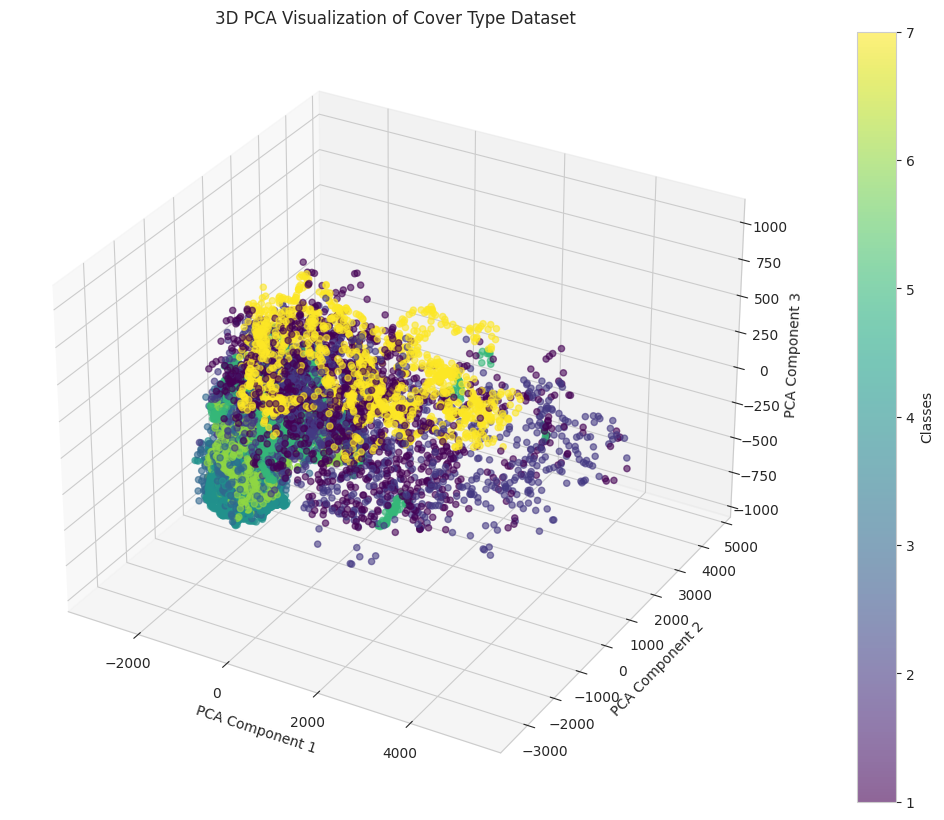

In [10]:
from sklearn.decomposition import PCA

X_pca = dataset.drop(columns=['Cover_Type'])
y_pca = dataset['Cover_Type']

pca = PCA(n_components=3)
X_embedded = pca.fit_transform(X_pca)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

num_points = 10000
sc = ax.scatter(X_embedded[:num_points, 0], X_embedded[:num_points, 1], X_embedded[:num_points, 2], c=y_pca[:num_points], cmap='viridis', alpha=0.6)

# Labels and title
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("3D PCA Visualization of Cover Type Dataset")

# Colorbar
plt.colorbar(sc, label="Classes")
plt.show()

t-SNE Visualization (We also did 3D)

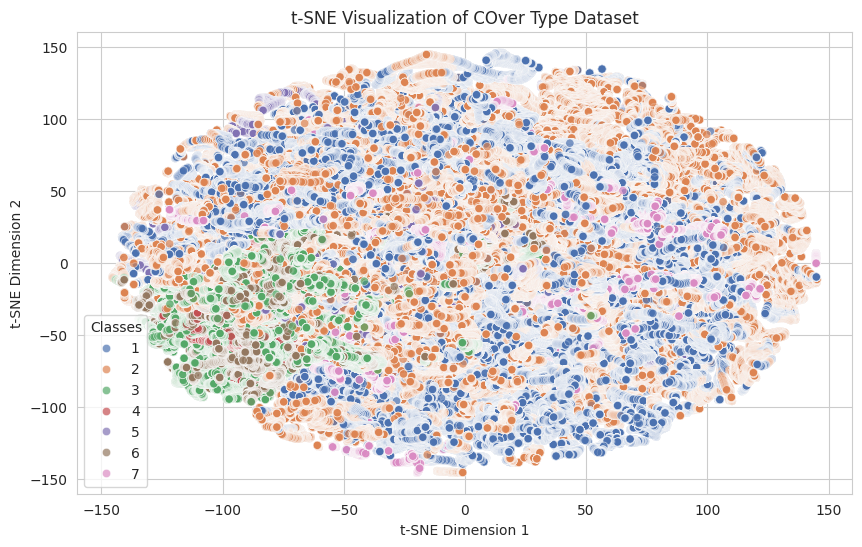

In [12]:
from sklearn.manifold import TSNE


X_tsne = dataset.drop(columns=['Cover_Type'])
y_tsne = dataset['Cover_Type']


tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_tsne)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_tsne, palette="deep", alpha=0.7)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of COver Type Dataset")
plt.legend(title="Classes")
plt.show()

Plot label distribution to look for imbalances

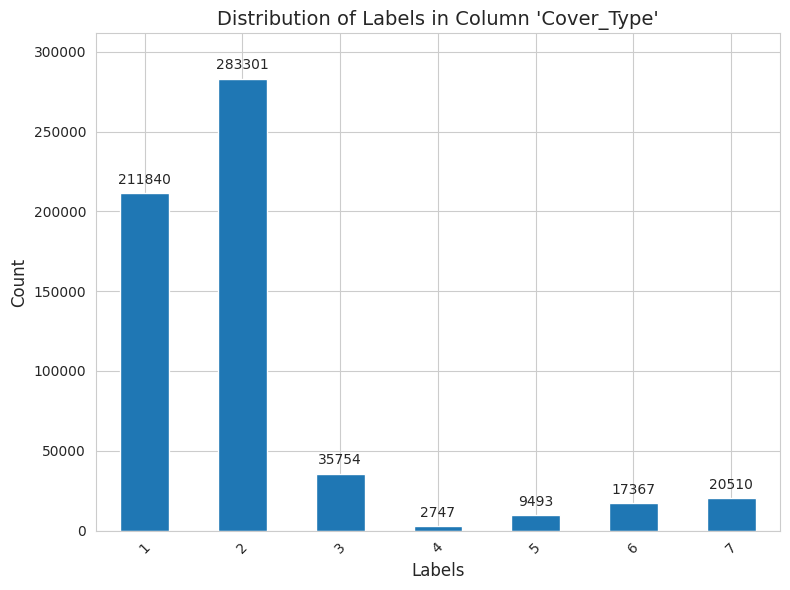

In [13]:
plot_label_distribution(y)

Look at feature corelations with target

/tmp/ipykernel_2112996/2451587485.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_absolute_correlation.index, y=average_absolute_correlation.values, palette="coolwarm", edgecolor="black")


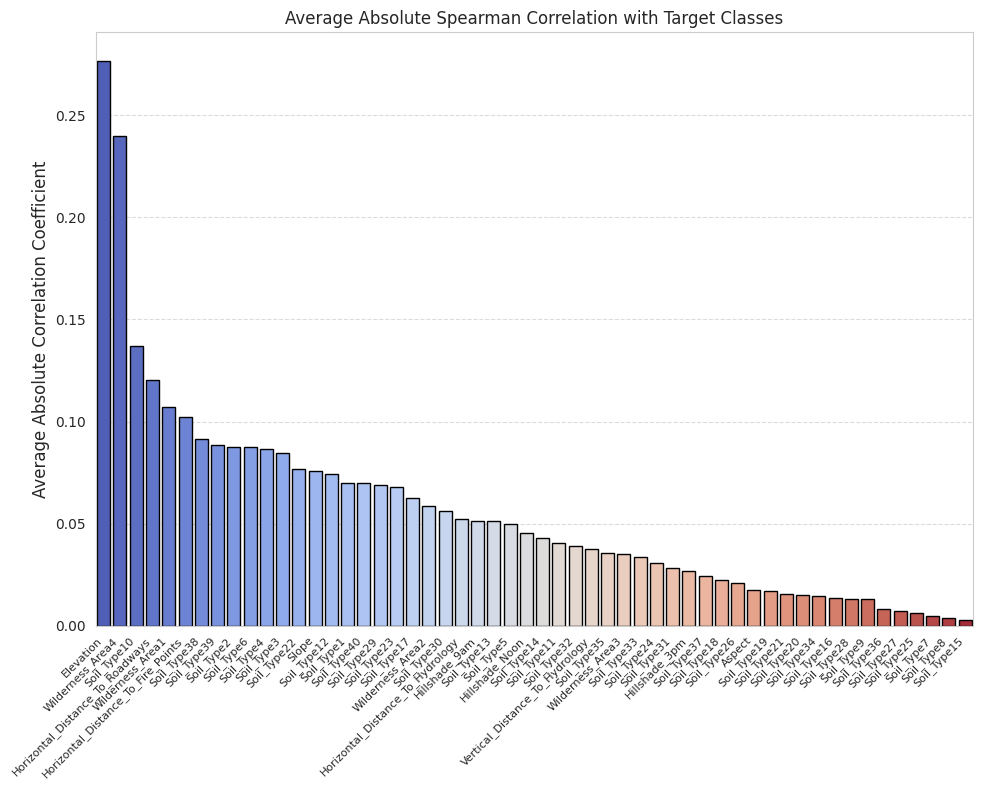

In [14]:
average_absolute_correlation_plot(dataset, 'Cover_Type', 'spearman')

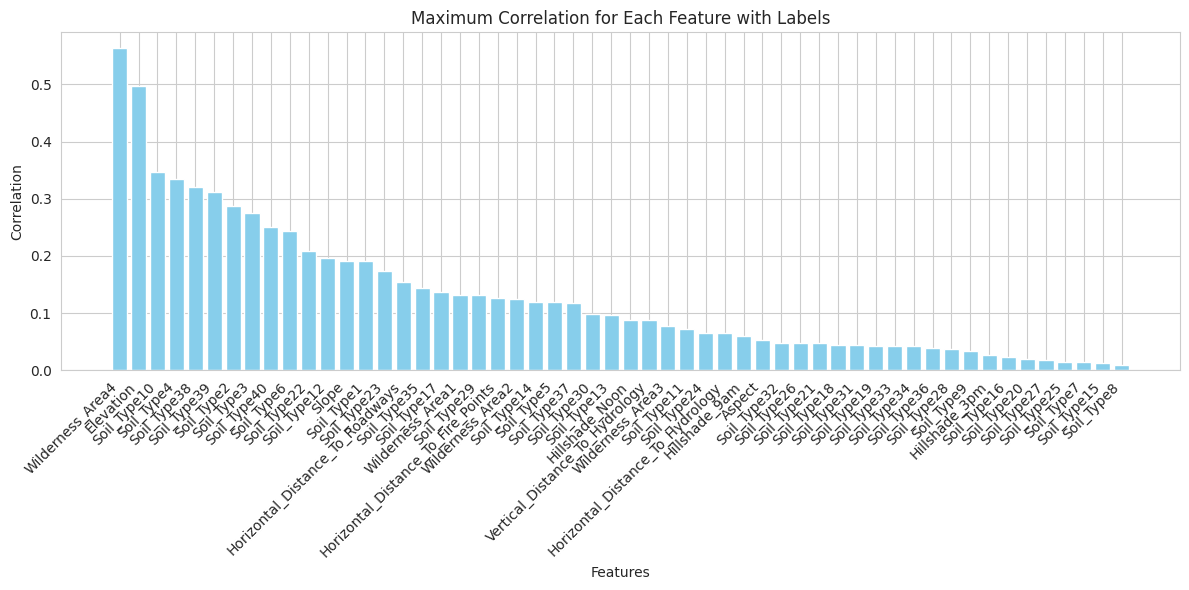

In [15]:
plot_max_correlation_for_features(dataset, target_column='Cover_Type')

Identify all features with max absolute correlation to any of the one hot encoded targets below 0.2

In [16]:
low_correlation_features = print_low_correlation_features(dataset, 'Cover_Type', threshold=0.2, method='spearman')

Features with absolute correlation below 0.2 for all target categories:
- Aspect
- Slope
- Horizontal_Distance_To_Hydrology
- Vertical_Distance_To_Hydrology
- Hillshade_9am
- Hillshade_Noon
- Hillshade_3pm
- Wilderness_Area2
- Wilderness_Area3
- Soil_Type1
- Soil_Type5
- Soil_Type7
- Soil_Type8
- Soil_Type9
- Soil_Type11
- Soil_Type12
- Soil_Type13
- Soil_Type14
- Soil_Type15
- Soil_Type16
- Soil_Type17
- Soil_Type18
- Soil_Type19
- Soil_Type20
- Soil_Type21
- Soil_Type23
- Soil_Type24
- Soil_Type25
- Soil_Type26
- Soil_Type27
- Soil_Type28
- Soil_Type29
- Soil_Type30
- Soil_Type31
- Soil_Type32
- Soil_Type33
- Soil_Type34
- Soil_Type35
- Soil_Type36
- Soil_Type37


#### 1.2. Dataset Preprocessing

First we reduce the dataset to be 2747 sample per class, which limits the size to reduce the runtime of algorithms, and also rebalances the dataset. Then we drop the low colleration features. We set X and y to the redistributed version, and from this point on we rely on that in the code.

/tmp/ipykernel_2112996/491746126.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), max_samples_per_label), random_state=42))


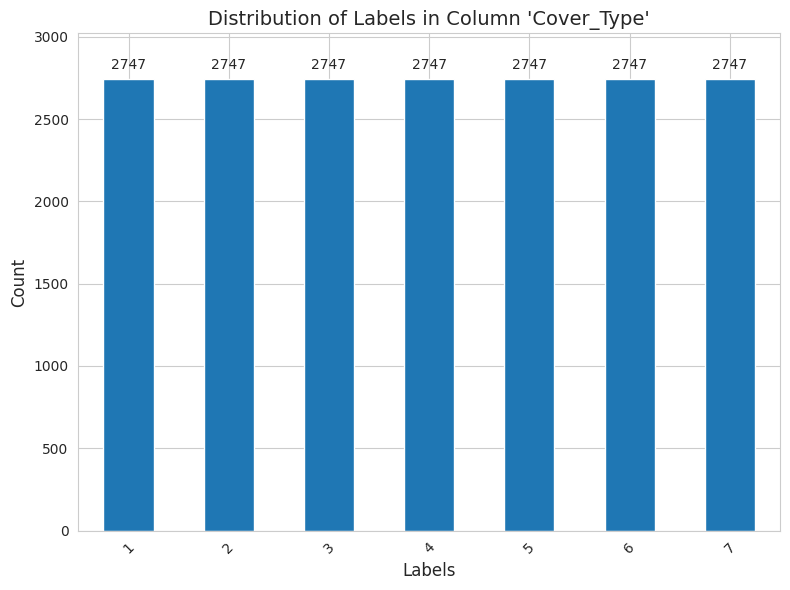

In [17]:
dataset_dropped = dataset.drop(columns=low_correlation_features) # drop redundant features
max_samples_per_label = 2747 # reduce the dataset size to contain at most 2747 samples per class, this also rebalances the dataset

dataset_reduced = (
    dataset_dropped.groupby('Cover_Type', group_keys=False)
      .apply(lambda x: x.sample(n=min(len(x), max_samples_per_label), random_state=42))
)

dataset_reduced = dataset_reduced.reset_index(drop=True)

X = dataset_reduced.drop(columns=['Cover_Type'])
y = dataset_reduced['Cover_Type']

plot_label_distribution(y)

Now we explore the pca reduction. We want to see how much variance can we capture, etc

Num Principal Components 1: Explained Variance = 0.7342
Num Principal Components 2: Explained Variance = 0.9670
Num Principal Components 3: Explained Variance = 1.0000
Num Principal Components 4: Explained Variance = 1.0000
Num Principal Components 5: Explained Variance = 1.0000
Num Principal Components 6: Explained Variance = 1.0000
Num Principal Components 7: Explained Variance = 1.0000
Num Principal Components 8: Explained Variance = 1.0000
Num Principal Components 9: Explained Variance = 1.0000
Num Principal Components 10: Explained Variance = 1.0000
Num Principal Components 11: Explained Variance = 1.0000
Num Principal Components 12: Explained Variance = 1.0000
Num Principal Components 13: Explained Variance = 1.0000
Num Principal Components 14: Explained Variance = 1.0000


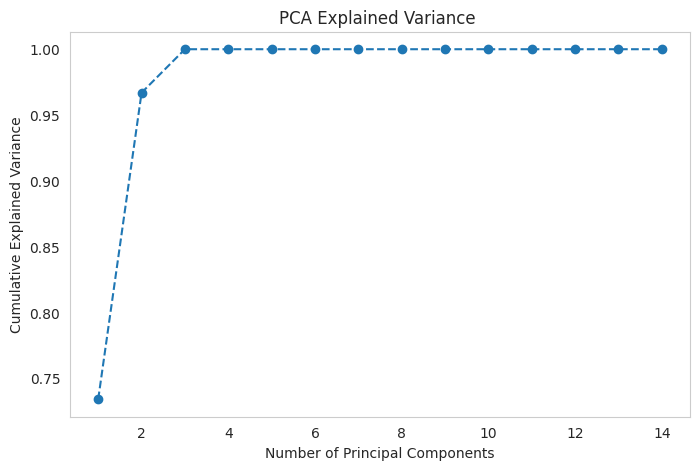

In [18]:
pca = PCA(n_components=None)
pca.fit(X)

cumulative_variance = pca.explained_variance_ratio_.cumsum()

for i, cum_var in enumerate(cumulative_variance, start=1):
    if i > 20:
        break
    print(f"Num Principal Components {i}: Explained Variance = {cum_var:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Explained Variance ')
plt.grid()
plt.show()

## 2. Baseline Classifier Training

Split the dataset to train and test.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [20]:
from sklearn.metrics import accuracy_score, classification_report


def classifiers_nested_grid_search(estimator, param_grid, experiment_description, X, y):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Outer CV
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)  # Inner CV

    best_params_list = []
    nested_scores = []

    classification_reports = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        print(f"Starting outer fold {fold_idx + 1}...")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', cv=inner_cv, n_jobs=-1, verbose=3)
        grid_search.fit(X_train, y_train)

        best_params_list.append(str(grid_search.best_params_))  

        best_estimator = grid_search.best_estimator_
        
        y_pred = best_estimator.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        nested_scores.append(accuracy)

        class_report = classification_report(y_test, y_pred)
        classification_reports.append(class_report)

        print(f"Accuracy for outer fold {fold_idx + 1}: {accuracy:.4f}")
        print(f"Classification Report for fold {fold_idx + 1}:\n", class_report)

    most_common_params = Counter(best_params_list).most_common(1)[0][0]
    best_params = eval(most_common_params)  

    return {
        'model': estimator.__class__.__name__,
        'best_params': best_params,
        'nested_cv_score': sum(nested_scores) / len(nested_scores),  # Average accuracy from nested CV
        'classification_reports': classification_reports,
        'description': experiment_description,
    }

svc_clf = SVC()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()

svc_param_grid = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['poly', 'rbf', 'linear'],
    'gamma': ['scale', 0.001, 0.1],
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['distance', 'uniform'],
    'metric': ['manhattan', 'euclidean', 'minkowski'],
    'n_jobs': [-1]
}

dt_param_grid = {
    'criterion': ['log_loss', 'entropy', 'log_loss'],
    'splitter': ['random', 'best'],
    'max_depth': [None, 3, 5, 7, 9, 11],
    'min_samples_split': [2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 5, 7]
}

description = "SVM Grid Search Nested CV Example"
nested_grid_search_results_svc = classifiers_nested_grid_search(svc_clf, svc_param_grid, description, X_train, y_train)

description = "KNN Grid Search Nested CV Example"
nested_grid_search_results_knn = classifiers_nested_grid_search(knn_clf, knn_param_grid, description, X_train, y_train)

description = "Decision Tree Grid Search Nested CV Example"
nested_grid_search_results_dt = classifiers_nested_grid_search(dt_clf, dt_param_grid, description, X_train, y_train)

pprint(nested_grid_search_results_svc)
pprint(nested_grid_search_results_knn)
pprint(nested_grid_search_results_dt)

Starting outer fold 1...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 3/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.531 total time=   2.8s
[CV 1/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.518 total time=   4.3s
[CV 2/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.541 total time=   4.4s
[CV 1/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.540 total time=   4.6s
[CV 2/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.510 total time=   6.3s
[CV 3/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.497 total time=   6.1s
[CV 2/3] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.139 total time=   7.9s
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.139 total time=   7.2s
[CV 1/3] END .....C=1, gamma=scale, kernel=poly;, score=0.583 total time=   3.1s
[CV 3/3] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.136 total time=  15.4s
[CV 2/3] END .....C=1, gamma=scale, kernel=poly;, score=0.599 total time=   3.2s
[CV 3/3] END .....C=1,

KeyboardInterrupt: 

In [31]:
from pprint import pprint
from collections import Counter
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

svc_clf = SVC(C=100, kernel='rbf', gamma='scale')
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan', n_jobs=-1)
dt_clf = DecisionTreeClassifier(criterion='log_loss', splitter='random', max_depth=None, min_samples_split=2, min_samples_leaf=1)


svc_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)

svc_y_pred = svc_clf.predict(X_test)
knn_y_pred = knn_clf.predict(X_test)
dt_y_pred = dt_clf.predict(X_test)

svc_accuracy = accuracy_score(y_test, svc_y_pred)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
dt_accuracy = accuracy_score(y_test, dt_y_pred)

svc_class_report = classification_report(y_test, svc_y_pred)
knn_class_report = classification_report(y_test, knn_y_pred)
dt_class_report = classification_report(y_test, dt_y_pred)

print("SVM Model Performance:")
print(f"Accuracy: {svc_accuracy:.4f}")
print("Classification Report:\n", svc_class_report)

print("KNN Model Performance:")
print(f"Accuracy: {knn_accuracy:.4f}")
print("Classification Report:\n", knn_class_report)

print("Decision Tree Model Performance:")
print(f"Accuracy: {dt_accuracy:.4f}")
print("Classification Report:\n", dt_class_report)

results = {
    'SVM': {
        'accuracy': svc_accuracy,
        'classification_report': svc_class_report
    },
    'KNN': {
        'accuracy': knn_accuracy,
        'classification_report': knn_class_report
    },
    'Decision Tree': {
        'accuracy': dt_accuracy,
        'classification_report': dt_class_report
    }
}

pprint(results)

SVM Model Performance:
Accuracy: 0.6312
Classification Report:
               precision    recall  f1-score   support

           1       0.61      0.60      0.60       403
           2       0.65      0.37      0.47       405
           3       0.45      0.50      0.48       424
           4       0.66      0.84      0.74       410
           5       0.66      0.87      0.75       404
           6       0.55      0.34      0.42       440
           7       0.82      0.92      0.87       399

    accuracy                           0.63      2885
   macro avg       0.63      0.64      0.62      2885
weighted avg       0.63      0.63      0.61      2885

KNN Model Performance:
Accuracy: 0.7366
Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.63      0.66       403
           2       0.66      0.50      0.57       405
           3       0.66      0.55      0.60       424
           4       0.76      0.90      0.82       410
    

## 3. Clustering Experiments

We first define the optimisation loop over the param grid, pca component counts, differnt scalers, different models, etc.

In [21]:
from collections import Counter
from sklearn.metrics import homogeneity_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
from scipy.stats import mode

def scale_selected_columns(df, columns_to_scale, scaler):
    if scaler is None:
        return df
    scaled_data = scaler.fit_transform(df[columns_to_scale])
    df_scaled = df.copy()
    df_scaled[columns_to_scale] = scaled_data
    return df_scaled

from sklearn.metrics import accuracy_score
from scipy.stats import mode
import numpy as np

def clustering_accuracy(y_true, y_pred):
    unique_clusters = np.unique(y_pred)
    cluster_to_label = {}

    for cluster in unique_clusters:
        mask = y_pred == cluster
        majority_label = mode(y_true[mask], keepdims=True).mode

        # ensure majority_label is properly indexed
        if isinstance(majority_label, np.ndarray) and majority_label.size > 0:
            majority_label = majority_label[0]
        
        cluster_to_label[cluster] = majority_label

    y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in y_pred])
    return accuracy_score(y_true, y_pred_mapped)


def clustering_grid_search(estimator, param_grid, scaling_type, pca_count, X, y):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    clustering_accuracy_scorer = make_scorer(clustering_accuracy)
    # accuracy_scorer = make_scorer(accuracy_score)
    # homogeneity_scorer = make_scorer(homogeneity_score)

    best_params_list = []
    nested_scores = []

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=clustering_accuracy_scorer, cv=inner_cv, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        best_params_list.append(str(grid_search.best_params_))

        best_estimator = grid_search.best_estimator_
        nested_score = clustering_accuracy(y_test, best_estimator.fit(X_train, y_train).predict(X_test))
        nested_scores.append(nested_score)

    most_common_params = Counter(best_params_list).most_common(1)[0][0]
    best_params = eval(most_common_params)

    pca_info = 'no_pca'
    if pca_count is not None:
        pca_info = pca_count

    return {
        'model': estimator.__class__.__name__,
        'best_params': best_params,
        'nested_cv_score': sum(nested_scores) / len(nested_scores),
        'scaler': scaling_type,
        'pca_count': pca_info,
        'dim': len(X.columns)
    }

def complete_optimization_clustering(models, param_grids, X, y, pca_counts, scaling_types):
    clustering_grid_search_results = []
    best_nested_cv_score = 0
    best_run = None
    
    for pca_count in pca_counts:    
        if pca_count is not None:
            print('\n#############################################################')
            print(f'                  Running for {pca_count} components')
            print('#############################################################\n')
            pca = PCA(n_components=pca_count)
            X_processed_1 = pd.DataFrame(pca.fit_transform(X), columns=[f'pca{i+1}' for i in range(pca_count)], index=X.index)
        else:
            print('\n#############################################################')
            print(f'                     Running without PCA')
            print('#############################################################\n')
            X_processed_1 = X
        
        for scaling_type in scaling_types:
            numerical_columns = X_processed_1.select_dtypes(include=['number']).columns.tolist()
            columns_to_scale = [col for col in numerical_columns if X_processed_1[col].nunique() > 2]
            scaler = MinMaxScaler() if scaling_type == 'min_max_scaler' else StandardScaler() if scaling_type == 'standard_scaler' else None
            X_processed_2 = scale_selected_columns(X_processed_1, columns_to_scale, scaler)
            
            print('start ------------------------------------------------------- \n')
            print('Running models for the following scaler and pca config:')
            description = f'scaler: {scaling_type}, num_principal_components: {pca_count}'
            print(description)

            for model, params in zip(models, param_grids):
                result = clustering_grid_search(model, params, scaling_type, pca_count, X_processed_2, y)

                if result['nested_cv_score'] > best_nested_cv_score:
                    best_nested_cv_score = result['nested_cv_score']
                    best_run = result
                
                clustering_grid_search_results.append(result)
                pprint(result)

            print('\nend ---------------------------------------------------------\n\n')
    
    return clustering_grid_search_results, best_run

#### 3.1 KNN-CLustering Grid Search

In [26]:
km_clustering = KMeans()

km_param_grid = {
    'n_clusters': [50],
    'init': ['k-means++', 'random'],
    'max_iter': [300, 500, 1000],         
    'tol': [1e-4, 1e-3, 1e-2],      
    'algorithm': ['lloyd', 'elkan'],
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

clustering_grid_search_results, best_run = complete_optimization_clustering([km_clustering], [km_param_grid], X_train, y_train, [None, 3, 5, 7, 10], ['min_max_scaler', 'standard_scaler', None])

print('\n\nBEST RUN:\n')
pprint(best_run)

with open("k_means_results", "w") as json_file:
    json.dump(clustering_grid_search_results, json_file, indent=4) 


#############################################################
                     Running without PCA
#############################################################

start ------------------------------------------------------- 

Running models for the following scaler and pca config:
scaler: min_max_scaler, num_principal_components: None
Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

Plot impact of cluster number on K-Means

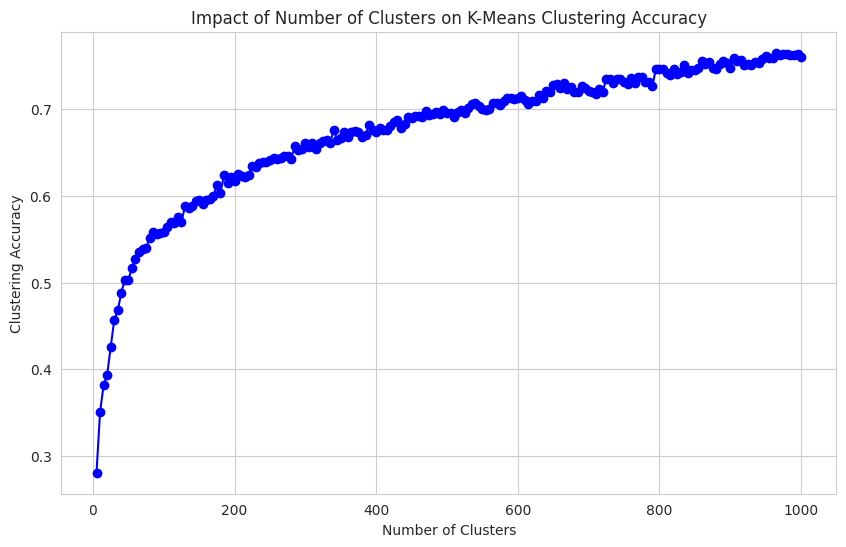

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.15, random_state=42)


n_clusters = np.arange(5, 1001, 5)
accuracies = []

for clusters in n_clusters:
    km_clustering = KMeans(n_clusters=clusters, init='random', algorithm='lloyd', max_iter=300, tol=0.001, random_state=42)
    km_clustering.fit(X_train)
    
    y_pred = km_clustering.predict(X_test)
    
    # Assuming clustering_accuracy is defined elsewhere
    accuracy = clustering_accuracy(y_test, y_pred)
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Clustering Accuracy')
plt.title('Impact of Number of Clusters on K-Means Clustering Accuracy')
plt.grid(True)
plt.show()


#### 3.2. Affinity Propagation Grid Search (Don't run this locally, your machine will just crash)

In [27]:
from sklearn.cluster import AffinityPropagation

ap_param_grid = {
    'damping': [0.5, 0.9],  # Controls cluster stability
    'preference': [-50, -10, 0],  # Influences the number of clusters
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

ap_clustering = AffinityPropagation()
clustering_grid_search_results, best_run = complete_optimization_clustering([ap_clustering], [ap_param_grid], X_train, y_train, [None, 3, 5, 7, 10], ['min_max_scaler', 'standard_scaler', None])

with open("affinity_propagation_results", "w") as json_file:
    json.dump(clustering_grid_search_results, json_file, indent=4) 


#############################################################
                     Running without PCA
#############################################################

start ------------------------------------------------------- 

Running models for the following scaler and pca config:
scaler: min_max_scaler, num_principal_components: None
Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: 

##### 3.3. MeanShift Clustering

In [28]:
from sklearn.cluster import MeanShift

ms_param_grid = {
    'bandwidth': ['auto', 1, 3, 5, 7, 15]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
ms_clustering = MeanShift()

clustering_grid_search_results, best_run = complete_optimization_clustering([ms_clustering], [ms_param_grid], X_train, y_train, [None, 3, 5, 7, 10], ['min_max_scaler', 'standard_scaler', None])

with open("mean_shift_results.json", "w") as json_file:
    json.dump(clustering_grid_search_results, json_file, indent=4) 


#############################################################
                     Running without PCA
#############################################################

start ------------------------------------------------------- 

Running models for the following scaler and pca config:
scaler: min_max_scaler, num_principal_components: None
Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: 

#### 3.4. Birch Clustering

In [29]:
from sklearn.cluster import Birch

birch_param_grid = {
    'n_clusters': [50],
    'threshold': [0.5, 1.0, 1.5],
    'branching_factor': [20, 50]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

birch_clustering = Birch()

clustering_grid_search_results, best_run = complete_optimization_clustering([birch_clustering], [birch_param_grid], X_train, y_train, [None, 3, 5, 7, 10], ['min_max_scaler', 'standard_scaler', None])

with open("birch_results_0_20_v2.json", "w") as json_file:
    json.dump(clustering_grid_search_results, json_file, indent=4) 


#############################################################
                     Running without PCA
#############################################################

start ------------------------------------------------------- 

Running models for the following scaler and pca config:
scaler: min_max_scaler, num_principal_components: None
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/home/franciszek-latala/.local/lib/python3.10/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (18) by BIRCH is less than (50). Decrease the threshold.
  warnings.warn(
/home/franciszek-latala/.local/lib/python3.10/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (50). Decrease the threshold.
  warnings.warn(
/home/franciszek-latala/.local/lib/python3.10/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (18) by BIRCH is less than (50). Decrease the threshold.
  warnings.warn(
/home/franciszek-latala/.local/lib/python3.10/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (50). Decrease the threshold.
  warnings.warn(
/home/franciszek-latala/.local/lib/python3.10/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (2) by BIRC

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/home/franciszek-latala/.local/lib/python3.10/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (50). Decrease the threshold.
  warnings.warn(
/home/franciszek-latala/.local/lib/python3.10/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (18) by BIRCH is less than (50). Decrease the threshold.
  warnings.warn(
/home/franciszek-latala/.local/lib/python3.10/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (50). Decrease the threshold.
  warnings.warn(
/home/franciszek-latala/.local/lib/python3.10/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (50). Decrease the threshold.
  warnings.warn(
/home/franciszek-latala/.local/lib/python3.10/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (16) by BIRC

KeyboardInterrupt: 

## 4. Some plotting based on the results

In [30]:
def plot_scaling_impact_on_homogeneity_bar(clustering_grid_search_results):
    df = pd.DataFrame(clustering_grid_search_results)
    
    required_columns = {'scaler', 'nested_cv_score', 'model'}
    if not required_columns.issubset(df.columns):
        raise ValueError("Results must contain 'scaler', 'nested_cv_score', and 'model' keys.")
    
    df['scaler'] = df['scaler'].apply(lambda x: 'None' if x is None else x)
    
    summary = (
        df.groupby(['model', 'scaler'])['nested_cv_score']
        .agg(['mean', 'min', 'max'])
        .reset_index()
    )

    summary['scaler_order'] = summary['scaler'].apply(lambda x: 0 if x == 'None' else 1)
    summary = summary.sort_values(by=['model', 'scaler_order', 'scaler']).drop(columns='scaler_order')
    
    models = summary['model'].unique()
    scalers = summary['scaler'].unique()
    
    x = np.arange(len(scalers))
    total_models = len(models)
    bar_width = 0.8 / total_models 
    
    plt.figure(figsize=(12, 7))
    
    for idx, model_name in enumerate(models):
        model_data = summary[summary['model'] == model_name]
        means = model_data['mean']
        mins = model_data['min']
        maxs = model_data['max']

        lower_errors = means - mins
        upper_errors = maxs - means
        error = [lower_errors, upper_errors]
        
        offset = (idx - total_models / 2) * bar_width + bar_width / 2
        positions = x + offset
        
        plt.bar(
            positions,
            means,
            bar_width,
            label=model_name,
            yerr=error,
            capsize=5,
            alpha=0.7
        )
    
    plt.xlabel("Scaler")
    plt.ylabel("Custom Accuracy")
    plt.title("Impact of Scaling on Clustering Accuracy")
    plt.xticks(x, scalers, rotation=45)
    plt.legend(title='Model')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

def plot_pca_impact_on_accuracy_best_result(clustering_grid_search_results):
    df = pd.DataFrame(clustering_grid_search_results)
    
    required_columns = {'pca_count', 'nested_cv_score', 'model'}
    if not required_columns.issubset(df.columns):
        raise ValueError(
            "Results must contain 'pca_count', 'nested_cv_score', and 'model' keys."
        )
    
    def to_numeric_pca_count(x):
        if x == 'no_pca':
            return 0
        return pd.to_numeric(x, errors='coerce')  # convert strings like "10" to int; invalid become NaN
    
    df['pca_count'] = df['pca_count'].apply(to_numeric_pca_count)
    
    best_df = (
        df.groupby(['model', 'pca_count'])['nested_cv_score']
        .max()
        .reset_index()
        .rename(columns={'nested_cv_score': 'best_score'})
    )
    
    plt.figure(figsize=(10, 6))
    for model_name, sub_df in best_df.groupby('model'):
        sub_df = sub_df.sort_values('pca_count')
        plt.plot(
            sub_df['pca_count'],
            sub_df['best_score'],
            marker='o',
            label=f"{model_name}"
        )
    
    unique_pca_counts = sorted(best_df['pca_count'].dropna().unique())
    x_labels = ["no_pca" if x == 0 else str(int(x)) for x in unique_pca_counts]
    plt.xticks(unique_pca_counts, x_labels)

    plt.xlabel("Number of PCA Components")
    plt.ylabel("Accuracy Score (Best Parameters)")
    plt.title("Best Clustering Score by Model and PCA Count (Aggregated Over Scalers)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

To load selected results for plotting, just load the jsons and add the lists together like below.

In [ ]:
with open("k_means_results.json", "r") as json_file:
    km_results = json.load(json_file)

with open("mean_shitf_results.json", "r") as json_file:
    ms_results = json.load(json_file)

with open("affinity_propagation_results.json", "r") as json_file:
    ap_results = json.load(json_file)

with open("birch_results.json", "r") as json_file:
    b_results = json.load(json_file)

full_results = km_results + ms_results + b_results + ap_results

In [ ]:
plot_scaling_impact_on_homogeneity_bar(full_results)

In [ ]:
plot_pca_impact_on_accuracy_best_result(full_results)

## 5. Clustering Final Evaluation / Inference

Method for evaluation. Important to note that we are splitting with the same seed, so we train on the same train and test on the same test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, homogeneity_score

def evaluate_clustering(estimator, X, y, pca_count=None, scaler=None):

    if pca_count is not None:
        pca = PCA(n_components=pca_count)
        X = pd.DataFrame(pca.fit_transform(X), index=X.index)

    if scaler is not None:
        numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
        columns_to_scale = [col for col in numerical_columns if X[col].nunique() > 2]
        X = scale_selected_columns(X, columns_to_scale, scaler)

    # splitting with the same seed, so we train on the same train and test on the same test
    X_train, X_test, _, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    estimator.fit(X_train)
    y_pred = estimator.predict(X_test)

    # 4. Compute metrics
    db_score = davies_bouldin_score(X_test, y_pred)
    homogeneity = homogeneity_score(y_test, y_pred)
    custom_score = clustering_accuracy(y_test, y_pred)

    print(f"Davies-Bouldin Score: {db_score}")
    print(f"Homogeneity Score: {homogeneity}")
    print(f"Custom Scoring Function Output: {custom_score}")

    return estimator

#### 5.1. KMeans Evaluation

In [ ]:
from sklearn.cluster import KMeans

km_best_params = {
    "n_clusters": 50,
    "init": "random",
    "max_iter": 500,
    "tol": 0.01,
    "algorithm": "lloyd"
}
model = KMeans(**km_best_params)

fitted_km = evaluate_clustering(model, X, y, pca_count=7, scaler=MinMaxScaler())

#### 5.2. Affinty Propagation Evaluation

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import MinMaxScaler

ap_params = {
    "damping": 0.5,
    "preference": 0
}
ap = AffinityPropagation(**ap_params)

fitted_ap = evaluate_clustering(
    estimator=ap, 
    X=X, 
    y=y, 
    pca_count=10, 
    scaler=MinMaxScaler()
)

labels_ap =fitted_ap.labels_
n_clusters_ap = len(np.unique(labels_ap))
print(n_clusters_ap)

#### 5.3. MeanShift Evaluation

In [ ]:
from sklearn.cluster import MeanShift

ms_params = {
    "bandwidth": 1
}

ms = MeanShift(**ms_params)

# Use scaler=None to skip scaling
fitted_ms = evaluate_clustering(
    estimator=ms, 
    X=X, 
    y=y, 
    pca_count=10, 
    scaler=None
)

#### 5.4. Birch Evaluation

In [ ]:
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler

birch_params = {
    "n_clusters": 50,
    "threshold": 0.5,
    "branching_factor": 20
}

birch_model = Birch(**birch_params)

fitted_birch = evaluate_clustering(
    estimator=birch_model, 
    X=X, 
    y=y, 
    pca_count=10, 
    scaler=StandardScaler()
)